In [1]:
# LIBRERIAS

import os
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

#Comprobar que Tensorflow reconoce la tarjeta gráfica del equipo
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# Lectura de ficheros con los datasets de las empresas a analizar

companies = {}
ficheros = os.listdir('data')

for file in ficheros:
    company = file[:-4]
    dfcompany = pd.read_csv(f"data/{file}")
    companies[company] = dfcompany

In [10]:
# Comprobación que de todas las empresas se dispone de al menos 1000 días de datos
for company in companies:
    dfcompany = companies[company]
    if dfcompany.shape[0] < 1000:
        print(company)

In [4]:
# Crreación de una matriz de datos de para la red neuronal
def create_dataset(dataset, look_back):
	x_data, y_data = [], []
	for i in range(len(dataset)-look_back-1):
		x = dataset[i:(i+look_back), 0]
		x_data.append(x)
		y = dataset[i + look_back, 0]
		y_data.append(y)
        
	return np.array(x_data), np.array(y_data)

def graficar(dfcompany, company):
	plt.plot(dfcompany)
	plt.xlabel('Days')
	plt.ylabel('Price')
	plt.title(label=company)

# Graficar el resultado
def graficarResultado(company, dfcompany, look_back, train_predict, test_predict, scaler):
    
    # Ajustamos los datos para mostrar la predicción
    trainPredictPlot = np.empty_like(dfcompany)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict
    
    testPredictPlot = np.empty_like(dfcompany)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(dfcompany)-1, :] = test_predict

    # Mostrar las los datos originales y la predicción
    plt.plot(scaler.inverse_transform(dfcompany), label='Original data')
    plt.plot(trainPredictPlot, label='Train prediction')
    plt.plot(testPredictPlot, label='Test prediction')
    plt.legend()
    plt.title(f'Predicción con modelo 1 para {company}')
    
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.show()
	
#Separar datos de entrenamiento y test
def split(dfcompany, look_back, percent=70):
    training_size = int(len(dfcompany)*percent) 
    test_size = len(dfcompany)-training_size 

    train_data, test_data = dfcompany[0:training_size,:], dfcompany[training_size:len(dfcompany),:1]


    #Creamos la matrix para los datos de entrenamiento y test    
    X_train, y_train = create_dataset(train_data, look_back) 
    X_test, y_test = create_dataset(test_data, look_back) 
    #print(f"La matriz X_train tiene la forma: {X_train.shape}")
    #print(f"La matriz y_train tiene la forma: {y_train.shape}")
    #print(f"La matriz X_test tiene la forma: {X_test.shape}")
    #print(f"La matriz y_test tiene la forma: {y_test.shape}")
    

    # Hay que hacer reshape a las entradas de la red LSTM añadiendo 1 dimension [samples, look_back, features]
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


    return X_train, X_test, y_train, y_test

In [5]:
def model_builder(hp):
  '''
  Args:
    hp - Keras tuner object
  '''
  # Initialize the Sequential API and start stacking the layers
  model = keras.Sequential()

  # Tune the number of units in the first LSTM layer
  # Choose an optimal value between 10-100
  hp_units0 = hp.Int('units0', min_value=10, max_value=100, step=20)
  model.add(LSTM(units=hp_units0, input_shape=(look_back,1), return_sequences=True, name='LSTM1'))

  # Tune the number of units in the second LSTM layer
  # Choose an optimal value between 10-100
  hp_units1 = hp.Int('units1', min_value=10, max_value=100, step=20)
  model.add(LSTM(units=hp_units1, name='LSTM2'))
  
  # Add next layers
  model.add(keras.layers.Dropout(0.2))
  model.add(Dense(1, activation='linear'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=['mse'])

  return model

In [6]:
def prediccion (model, X_train, X_test, y_train, y_test, look_back, scaler):
    # Realizar predicción sobre datos de entranamiento y test
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Transformamos los datos a su escala original
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    return  train_predict, test_predict

def generarHipermodelo(X_train, y_train, X_test, y_test): 
    # Perform hypertuning
    tuner.search(X_train, y_train, epochs=10, validation_data=(X_test,y_test), callbacks=[stop_early]) 

    best_hp = tuner.get_best_hyperparameters()[0]

    # Build the model with the optimal hyperparameters
    h_model = tuner.hypermodel.build(best_hp)
    h_model.summary()
    print(tuner.get_best_hyperparameters()[0].get('learning_rate'))

    return h_model

def generarResultados(dfcompany):
    #dfcompany = companies[company]
    # Por cada empresa, preprocesar, entrenar y guardar resultados
    company = dfcompany.iloc[0,0]

    # Descartamos todas las columnas y nos quedamos unicamente con el precio de cierre de la acción
    dfcompany = dfcompany.reset_index()['close']
    scaler=MinMaxScaler(feature_range=(0,1))
    dfcompany = scaler.fit_transform(np.array(dfcompany).reshape(-1,1))
    X_train, X_test, y_train, y_test = split(dfcompany, look_back, percent=0.90)

    h_model = generarHipermodelo(X_train, y_train, X_test, y_test)
    #Entrenamiento del modelo mejorado
    history = h_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[stop_early])

    train_predict, test_predict = prediccion(h_model, X_train, X_test, y_train, y_test, look_back, scaler)

    # Calculamos el error en entrenamiento y test
    train_error = math.sqrt(mean_squared_error(y_train, train_predict))
    test_error = math.sqrt(mean_squared_error(y_test, test_predict))

    print(f"Para la empresa {company}")
    print(f"Error entrenamiento: {train_error}")
    print(f"Error test: {test_error}")

    graficarResultado(company, dfcompany, look_back, train_predict, test_predict, scaler)
    return (train_error, test_error)


In [7]:
# Tomamos datos para el modelo
dfcompany = companies['NVDA']
dfcompany

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,NVDA,2017-05-30 00:00:00+00:00,144.87,146.2911,143.0500,143.70,24580778,35.823170,36.174577,35.373124,35.533855,98323112,0.0,1.0
1,NVDA,2017-05-31 00:00:00+00:00,144.35,147.0000,142.0500,146.69,21643194,35.694586,36.349872,35.125846,36.273216,86572776,0.0,1.0
2,NVDA,2017-06-01 00:00:00+00:00,144.36,145.0300,142.5200,144.99,12462061,35.697058,35.862735,35.242067,35.852843,49848244,0.0,1.0
3,NVDA,2017-06-02 00:00:00+00:00,143.64,145.3000,143.4000,144.24,12140804,35.519018,35.929500,35.459671,35.667385,48563216,0.0,1.0
4,NVDA,2017-06-05 00:00:00+00:00,148.01,148.5300,142.5100,142.98,20311623,36.599623,36.728208,35.239594,35.355815,81246492,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,NVDA,2022-05-20 00:00:00+00:00,166.94,174.1000,157.5500,173.32,73910526,166.940000,174.100000,157.550000,173.320000,73910526,0.0,1.0
1255,NVDA,2022-05-23 00:00:00+00:00,168.98,169.1500,161.7901,162.74,63988869,168.980000,169.150000,161.790100,162.740000,63988869,0.0,1.0
1256,NVDA,2022-05-24 00:00:00+00:00,161.54,165.9700,157.8000,165.10,58855002,161.540000,165.970000,157.800000,165.100000,58855002,0.0,1.0
1257,NVDA,2022-05-25 00:00:00+00:00,169.75,171.1099,160.0000,160.20,78113190,169.750000,171.109900,160.000000,160.200000,78113190,0.0,1.0


In [8]:
# Definimos cuantos días usará el modelo para predecir el día siguiente
look_back = 50

# Instanciamos el tuner
tuner = kt.Hyperband(model_builder, # the hypermodel
                    objective='val_loss', # objective to optimize
                    max_epochs=10,
                    factor=3, # the denominator of the number of models trained in every iteration of the training loop.
                    directory='keras_tuner_dir', # directory to save logs 
                    project_name='Stock_prediction')

# hypertuning settings
tuner.search_space_summary() 

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=10, min_delta=0.2)

INFO:tensorflow:Reloading Oracle from existing project keras_tuner_dir\Stock_prediction\oracle.json
INFO:tensorflow:Reloading Tuner from keras_tuner_dir\Stock_prediction\tuner0.json
Search space summary
Default search space size: 3
units0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 20, 'sampling': None}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 20, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


INFO:tensorflow:Oracle triggered exit
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM1 (LSTM)                 (None, 50, 90)            33120     
_________________________________________________________________
LSTM2 (LSTM)                 (None, 30)                14520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 47,671
Trainable params: 47,671
Non-trainable params: 0
_________________________________________________________________
0.01
Epoch 1/50
14/14 [==============================] - 10s 110ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0575 - val_mse: 0.0575
Epoch 2/50
14/14 [==============================] - 0s 17ms/step - loss:

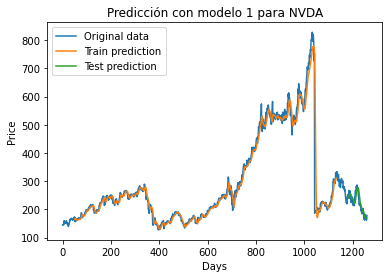

In [9]:
train_error, test_error = generarResultados(dfcompany)